Train an embedding given a batch of data collected by a successful run.

In [450]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import tensorflow as tf
import glob
import math
import skimage

tf.enable_eager_execution()

In [451]:
from IPython.display import clear_output

## Load a Checkpoint (for the environment and replay pool)

In [452]:
common_dir = '/Users/kevintli/rail/data/ray_results'
universe = 'gym'
domain = 'Point2D'
task = 'Maze-v0'

In [548]:
base_path = os.path.join(common_dir, universe, domain, task)
exps = sorted(list(glob.iglob(os.path.join(base_path, '*'))))
for i, exp in enumerate(exps):
    print(f'{i} \t {exp.replace(base_path, "")}')
    
exp_choice = int(input('\n Which experiment do you want to analyze? (ENTER A NUMBER) \t'))

exp_path = exps[exp_choice]
print('\n')
seeds = sorted(list(glob.iglob(os.path.join(exp_path, '*'))))
seeds = [seed for seed in seeds if os.path.isdir(seed)]
for i, seed in enumerate(seeds):
    print(f'{i} \t {seed.replace(exp_path, "")}')

# TODO: Extend to analyzing all seeds
seed_choice = int(input('\n Which seed do you want to analyze? (ENTER A NUMBER) \t'))

seed_path = seeds[seed_choice]

print('PATH:\n', seed_path)

0 	 /2020-05-27T18-08-07-ddl_maze_count
1 	 /2020-06-09T14-32-56-ddl_rerun_count

 Which experiment do you want to analyze? (ENTER A NUMBER) 	1


0 	 /id=c8f673b6-seed=4909_2020-06-09_14-32-57cykb7ts3
1 	 /id=c8f70b1e-seed=2831_2020-06-09_14-32-57i3fmyfto
2 	 /id=c8f776a8-seed=1236_2020-06-09_14-32-58e87tb95v
3 	 /id=c8f98ad8-seed=4579_2020-06-09_14-32-585z8fri5g
4 	 /id=c8fa08c8-seed=8024_2020-06-09_14-32-5838elsjoh
5 	 /id=c8fa7952-seed=6693_2020-06-09_14-32-587lzybz5p
6 	 /id=c8fb8fae-seed=571_2020-06-09_14-32-58yzbojvg_
7 	 /id=c8fc0bc8-seed=2811_2020-06-09_14-32-581911_wkt
8 	 /id=c8fc87ec-seed=9671_2020-06-09_14-32-58xo4787dk
9 	 /id=c8fd0064-seed=9464_2020-06-09_14-32-580zvoxv0p
10 	 /id=c8fd7774-seed=6840_2020-06-09_14-32-5894pxpirz
11 	 /id=c8fdf122-seed=524_2020-06-09_14-32-58pfm8y3w5

 Which seed do you want to analyze? (ENTER A NUMBER) 	4
PATH:
 /Users/kevintli/rail/data/ray_results/gym/Point2D/Maze-v0/2020-06-09T14-32-56-ddl_rerun_count/id=c8fa08c8-seed=8024_2020-06-09_14-

## Initialize Replay Pool & Load Experience from All Checkpoints

In [549]:
from softlearning.replay_pools.utils import get_replay_pool_from_variant

checkpoint, variant, train_env, replay_pool = None, None, None, None

############################################ 
# Load data from all seeds, all checkpoints
############################################
# for seed_path in seeds:
for ckpt_path in glob.iglob(os.path.join(seed_path, 'checkpoint_*')):
    if not replay_pool:
        with open(os.path.join(ckpt_path, "checkpoint.pkl"), 'rb') as f:
            checkpoint = pickle.load(f)    
        variant = checkpoint['variant']
        variant['replay_pool_params']['kwargs']['max_size'] = int(1e6)
        train_env = checkpoint['training_environment']
        replay_pool = get_replay_pool_from_variant(variant, train_env)

    replay_pool_path = os.path.join(ckpt_path, 'replay_pool.pkl')
    replay_pool.load_experience(replay_pool_path)

#################################################
# Load data from a specific seed + checkpoint
#################################################
# c_num = 200
# checkpoint_dir = f'{seed_path}/checkpoint_{c_num}'
# with open(os.path.join(checkpoint_dir, 'checkpoint.pkl'), 'rb') as f:
#     checkpoint = pickle.load(f)   
#     variant = checkpoint['variant']
#     variant['replay_pool_params']['kwargs']['max_size'] = int(1e6)
#     train_env = checkpoint['training_environment']
#     replay_pool = get_replay_pool_from_variant(variant, train_env)
#     replay_pool_path = os.path.join(checkpoint_dir, 'replay_pool.pkl')
#     replay_pool.load_experience(replay_pool_path)
    
# replay_pool = get_replay_pool(checkpoint, checkpoint_dir)

W0611 01:59:08.631482 140736058082176 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0611 01:59:08.778927 140736058082176 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0611 01:59:08.920444 140736058082176 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [550]:
seed_path

'/Users/kevintli/rail/data/ray_results/gym/Point2D/Maze-v0/2020-06-09T14-32-56-ddl_rerun_count/id=c8fa08c8-seed=8024_2020-06-09_14-32-5838elsjoh'

201000


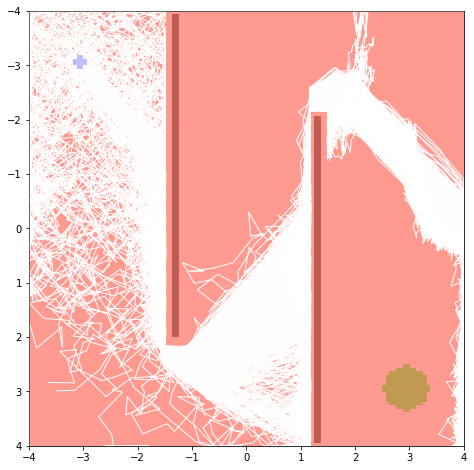

In [554]:
print(replay_pool.size)
num_trajectories = replay_pool.size // max_path_length

plt.figure(figsize=(8, 8))
plt.imshow(train_env.render('rgb_array', width=128, height=128),
           extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)
plt.gca().invert_yaxis()
plt.gca().set_facecolor('xkcd:salmon')

trajectories = replay_pool.last_n_batch(100 * num_trajectories)['observations']['state_observation'] \
                    .reshape(num_trajectories, 100, -1)
for i in range(num_trajectories):
    plt.plot(trajectories[i,:,0], trajectories[i,:,1], color='w', linewidth=1)

Model: "picklable_model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
s1/state_observation (InputLaye [(None, 2)]          0                                            
__________________________________________________________________________________________________
s2/state_observation (InputLaye [(None, 2)]          0                                            
__________________________________________________________________________________________________
distance_estimator (PicklableSe (None, 1)            67329       s1/state_observation[0][0]       
                                                                 s2/state_observation[0][0]       
Total params: 67,329
Trainable params: 67,329
Non-trainable params: 0
__________________________________________________________________________________________________
3.0 3.0


TypeError: You must first set_array for mappable

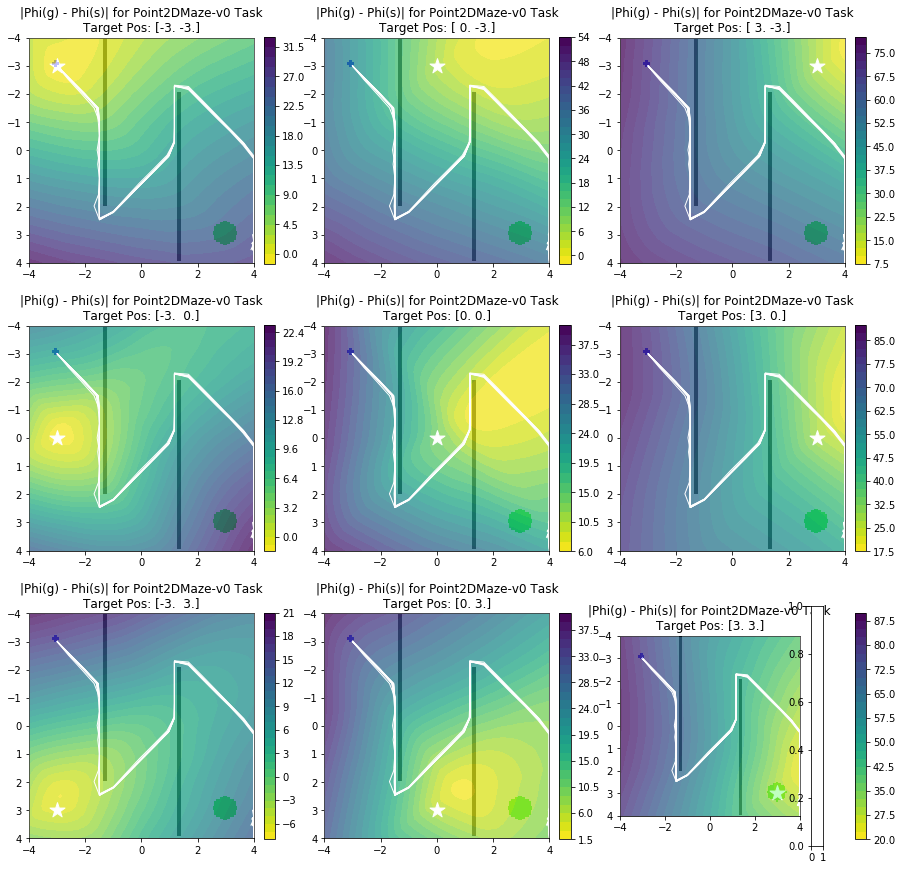

In [555]:
distance_fn = checkpoint['distance_estimator']
distance_fn.summary()
plot_embedding_distances_grid(dist_fn=lambda s1, s2: distance_fn.predict([s1, s2]), show_trajectories=True)

## Define helper functions

In [572]:
from softlearning.replay_pools.utils import get_replay_pool_from_variant

def get_grid_vals(env, n_samples):
    n_samples = 50
    obs_space = env.observation_space['state_observation']
    xs = np.linspace(obs_space.low[0], obs_space.high[0], n_samples)
    ys = np.linspace(obs_space.low[1], obs_space.high[1], n_samples)
    xys = np.meshgrid(xs, ys)
    return np.array(xys).transpose(1, 2, 0).reshape((n_samples * n_samples, 2)), xys

def get_replay_pool(checkpoint, checkpoint_dir):
    from softlearning.replay_pools.utils import get_replay_pool_from_variant

    variant = checkpoint['variant']
    train_env = checkpoint['training_environment']
    replay_pool = get_replay_pool_from_variant(variant, train_env)

    replay_pool_path = os.path.join(checkpoint_dir, 'replay_pool.pkl')
    replay_pool.load_experience(replay_pool_path)
    return replay_pool

def plot_distances(dist_fn=None, postprocess=None, target_pos=None, show_trajectories=False, title=None, create_plot=True):

    postprocess = postprocess or (lambda x: x)
    target_pos = target_pos if target_pos is not None else train_env.unwrapped._get_obs()['state_desired_goal']

    n_samples = 50
    obs_space = train_env.observation_space['state_observation']
    xs = np.linspace(obs_space.low[0], obs_space.high[0], n_samples)
    ys = np.linspace(obs_space.low[1], obs_space.high[1], n_samples)

    xys = np.meshgrid(xs, ys)

    grid_vals = np.array(xys).transpose(1, 2, 0).reshape((n_samples * n_samples, 2))
    goal_vals = np.repeat(target_pos[None], n_samples * n_samples, axis=0)
    dists = postprocess(dist_fn(grid_vals, goal_vals))

    if create_plot:
        plt.figure(figsize=(8, 8))

    plt.imshow(train_env.render('rgb_array', width=256, height=256),
               extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)

    plt.gca().invert_yaxis()
    plt.contourf(xys[0], xys[1], dists.reshape(xys[0].shape), levels=30, zorder=1, cmap='viridis_r')
    plt.colorbar(fraction=0.046, pad=0.04)    
    
    if show_trajectories:
        plot_trajectories(checkpoint, checkpoint_dir)

    plt.scatter(*target_pos, marker='*', s=250, color='white', zorder=2)

    plt.title((title or 'd(s, g)') + f' for {domain + task} Task\n'
              + f'Target Pos: {target_pos}')
    
    if create_plot:
        plt.show()

def plot_embedding_distances(pos_embedding=None, goal_embedding=None, dist_fn=None, postprocess=None, 
                             target_pos=None, show_trajectories=False, title=None, create_plot=True):
        
    pos_embedding = pos_embedding or embedding_fns[0]
    goal_embedding = goal_embedding or embedding_fns[1]
    
    if not dist_fn:
        def dist_fn(s1, s2):
            return np.sum((goal_embedding(s2) - pos_embedding(s1)) ** 2, axis=-1)
              
    plot_distances(dist_fn=dist_fn, postprocess=postprocess, target_pos=target_pos,
                      show_trajectories=show_trajectories, title='|Phi(g) - Phi(s)|', create_plot=create_plot)
        
def plot_embedding_distances_grid(**kwargs):
    xs = np.linspace(-3, 3, 3)
    ys = np.linspace(-3, 3, 3)
    xys = np.meshgrid(xs, ys)
    goal_vals = np.array(xys).transpose(1, 2, 0).reshape((9, 2))

    n_plots = len(goal_vals)
    n_columns = np.ceil(np.sqrt(n_plots))
    n_rows = np.ceil(n_plots / n_columns)
    print(n_rows, n_columns)
    plt.figure(figsize=(5 * n_columns, 5 * n_rows))

    for i, goal in enumerate(goal_vals):
        plt.subplot(n_rows, n_columns, i+1, aspect=1)
        plot_embedding_distances(**kwargs, target_pos=goal, create_plot=False)

def plot_trajectories(checkpoint, checkpoint_dir, num_trajectories=10):
    replay_pool = get_replay_pool(checkpoint, checkpoint_dir)
    trajectories = replay_pool.last_n_batch(100 * num_trajectories)['observations']['state_observation'] \
                    .reshape(num_trajectories, 100, -1)
    for i in range(num_trajectories):
        plt.plot(trajectories[i,:,0], trajectories[i,:,1], color='w', linewidth=1)

## Initialize the Embedding Function

In [566]:
from softlearning.models.utils import get_embedding_from_variant

variant['distance_fn_params'] = {
    'type': 'feedforward_distance_fn',
    'kwargs': {
        'hidden_layer_sizes': (256, ) * 2,
        'observation_keys': None,
        'embedding_dim': 16,
        'observation_keys': ('state_observation', ),
        'kernel_regularizer': tf.keras.regularizers.l2(5e-4)
    }
}

embedding_fn = get_embedding_from_variant(variant, train_env)

## Option 1: Use separate embedding functions for s1, s2
# embedding_fn_copy = tf.keras.models.clone_model(embedding_fn)
# embedding_fns = [embedding_fn, embedding_fn_copy]

## Option 2: Use single embedding function for both s1 and s2
embedding_fns = [embedding_fn, embedding_fn]

## Define Training Helper Functions

In [508]:
def get_data(replay_pool, max_path_length, batch_size=256, clip_length=10):
    """
    Get data for DDL-style training using the replay pool.
    """
    s1_indices = replay_pool.random_indices(batch_size)

    # Clip at a certain amount?
    distances = np.minimum(np.random.randint(max_path_length - s1_indices % max_path_length), clip_length)
    s2_indices = s1_indices + distances

    s1 = replay_pool.batch_by_indices(s1_indices)
    s2 = replay_pool.batch_by_indices(s2_indices)
    distances = distances.astype(np.float32)[..., None]
    
    return s1, s2, distances

In [532]:
def get_distance_fn_labeled_data(replay_pool, max_path_length, dist_fn=distance_fn, batch_size=256):
    """
    Get data for DDL-style training using the replay pool.
    """
    s1_indices = replay_pool.random_indices(batch_size)
    s2_indices = replay_pool.random_indices(batch_size)

    # Clip at a certain amount?
    distances = np.minimum(np.random.randint(max_path_length - s1_indices % max_path_length), 100)
    s2_indices = s1_indices + distances

    s1 = replay_pool.batch_by_indices(s1_indices)
    s2 = replay_pool.batch_by_indices(s2_indices)
#     distances = dist_fn.predict([s1['observations']['state_observation'], s2['observations']['state_observation']])
    
    return s1, s2, distances

In [510]:
max_path_length

100

In [511]:
def ground_truth_data(gt_distance_fn, max_path_length, batch_size=256, clip_length=10):
    """
    Get data for training a ground truth embedding function
    *using actual replay pool data*.
    """
    s1_indices = replay_pool.random_indices(batch_size)

    # Clip at a certain amount?
    distances = np.minimum(np.random.randint(max_path_length - s1_indices % max_path_length), clip_length)
    s2_indices = s1_indices + distances

    s1 = replay_pool.batch_by_indices(s1_indices)['observations']['state_observation']
    s2 = replay_pool.batch_by_indices(s2_indices)['observations']['state_observation']
    distances = gt_distance_fn(s1, s2)
    
    return s1, s2, distances

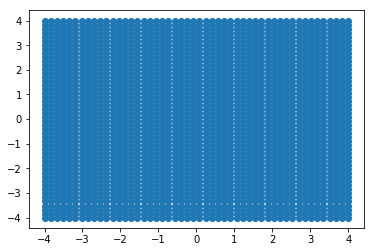

In [512]:
grid_vals, xys = get_grid_vals(train_env, 50)
plt.scatter(xys[0], xys[1])

In [513]:
def ground_truth_data_uniform(gt_distance_fn, batch_size=256, resolution=50):
    """
    Get data for training a ground truth embedding function
    on pairs of points sampled uniformly across the entire space.
    
    *This gives much better performance on predicting distances between arbitrary points!*
    """
    grid_vals, _ = get_grid_vals(train_env, resolution)
    s1_indices = np.random.choice(len(grid_vals), batch_size)
    s2_indices = np.random.choice(len(grid_vals), batch_size)
    s1, s2 = grid_vals[s1_indices], grid_vals[s2_indices]
    distances = gt_distance_fn(s1, s2)
    
    return s1, s2, distances

In [514]:
optimizer = tf.compat.v1.train.AdamOptimizer(
    learning_rate=3e-4,
    name='embedding_fn_optimizer')

loss_object = tf.keras.losses.MeanSquaredError()
# loss_object = tf.keras.losses.Huber(delta=0.05, reduction=tf.compat.v1.losses.Reduction.NONE)
def loss(models, s1, s2, distance):
    pred = tf.reduce_sum(tf.square(models[1](s2) - models[0](s1)), axis=-1)
#     loss_unweighted = (distance - pred) ** 2
#     weights = tf.clip_by_value(10 / (distance+1e-12), 0.2, 10)
    return loss_object(y_pred=pred, y_true=distance)
#     return tf.compat.v1.losses.compute_weighted_loss(loss_unweighted, weights)


def grad(models, var_list, s1, s2, distance):
    with tf.GradientTape() as tape:
        loss_value = loss(models, s1, s2, distance)
    return loss_value, tape.gradient(loss_value, var_list)

## Plot True Distances to Learn

In [515]:
def _generalized_maze_distance(self, obs, dist_type="manhattan"):
    # Maze wall positions
    left_wall_x = -self.boundary_dist/3
    left_wall_bottom = self.inner_wall_max_dist
    right_wall_x = self.boundary_dist/3
    right_wall_top = -self.inner_wall_max_dist
    
    s1 = obs['state_achieved_goal'].copy()
    s2 = obs['state_desired_goal'].copy()
    
    # Since maze distances are symmetric, redefine s1,s2 for convenience 
    # so that points in s1 are to the left of those in s2
    combined = np.hstack((s1[:,None], s2[:,None]))
    indices = np.argmin((s1[:,0], s2[:,0]), axis=0)
    s1 = np.take_along_axis(combined, indices[:,None,None], axis=1).squeeze(axis=1)
    s2 = np.take_along_axis(combined, 1 - indices[:,None,None], axis=1).squeeze(axis=1)
    
    x1 = s1[:,0]
    x2 = s2[:,0]
    
    # Horizontal movement
    x_dist = np.abs(x2 - x1)
    
    # Vertical movement
    boundary_ys = [left_wall_bottom, right_wall_top, 0]
    boundary_xs = [left_wall_x, right_wall_x, self.boundary_dist, -4.0001]
    y_directions = [1, -1, 0] # +1 means need to get to bottom, -1 means need to get to top
    curr_y, goal_y = s1[:,1], s2[:,1]
    y_dist = np.zeros(len(s1))
    
    for i in range(3):
        # Get all points where s1 and s2 respectively are in the current vertical section of the maze
        curr_in_section = x1 <= boundary_xs[i]
        goal_in_section = np.logical_and(boundary_xs[i-1] < x2, x2 <= boundary_xs[i])
        goal_after_section = x2 > boundary_xs[i]
        
        # Both in current section: move directly to goal
        mask = np.logical_and(curr_in_section, goal_in_section)
        y_dist += mask * np.abs(curr_y - goal_y)
        curr_y[mask] = goal_y[mask]
        
        # s2 is further in maze: move to next corner
        mask = np.logical_and(curr_in_section, np.logical_and(goal_after_section, y_directions[i] * (boundary_ys[i] - curr_y) > 0))
        y_dist += mask * np.clip(y_directions[i] * (boundary_ys[i] - curr_y), 0, None)
        curr_y[mask] = boundary_ys[i]
        
    return x_dist + y_dist

obs = {
    'state_achieved_goal': np.array([[-3.5, 3]]),
    'state_desired_goal': np.array([[-3.5, 1]])
}
# Should be 2
_generalized_maze_distance(train_env, obs, dist_type="manhattan")

array([2.])

In [516]:
np.logical_and(np.array(True), np.array(True), np.array(False))

array(True)

3.0 3.0


TypeError: You must first set_array for mappable

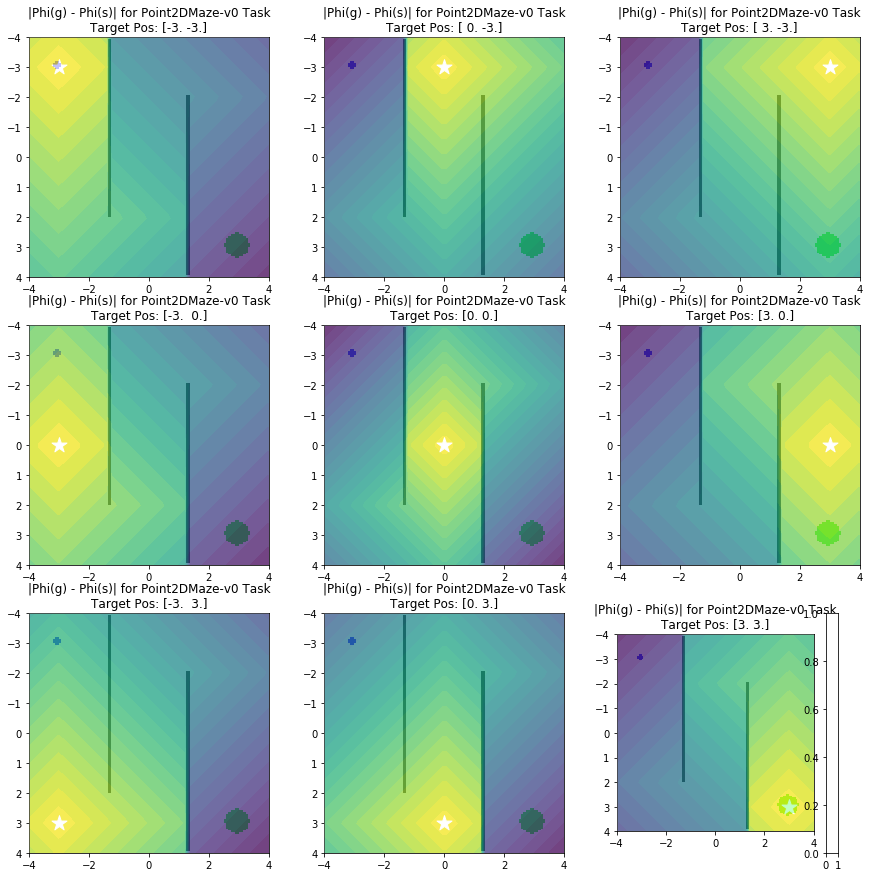

In [538]:
# Distances to various positions in maze
true_embedding = lambda s1, s2: _generalized_maze_distance(train_env, \
                                        {'state_achieved_goal': s1, 'state_desired_goal': s2})
plot_embedding_distances_grid(dist_fn=true_embedding)

## Train using sampled data

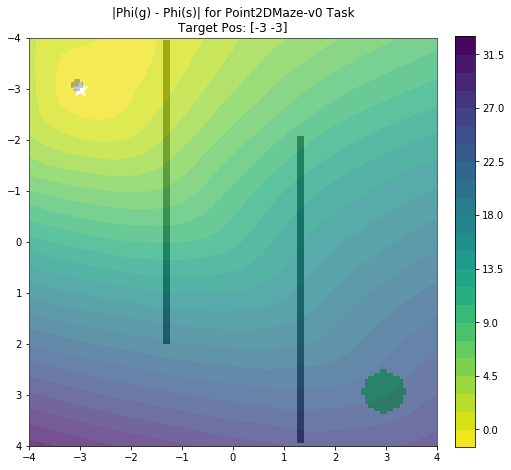

[[23.93361]]
[[79.56275]]


In [518]:
plot_embedding_distances(dist_fn=lambda s1,s2: distance_fn.predict([s1, s2]), target_pos=np.array([-3, -3]))
print(distance_fn.predict([np.array([[3, 3]]), np.array([[-3, -3]])]))
print(distance_fn.predict([np.array([[-3, -3]]), np.array([[3, 3]])]))

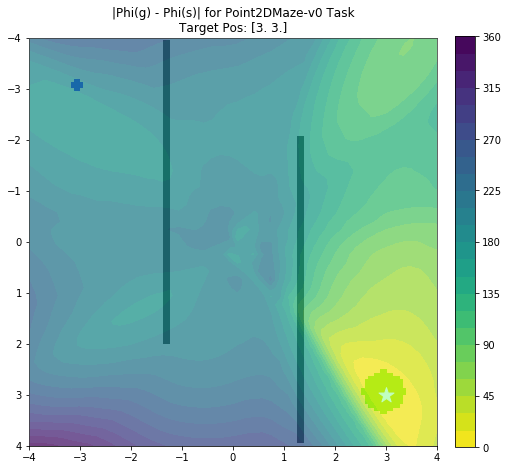

Epoch 460: Loss: 19.285
Epoch 470: Loss: 18.233
Epoch 480: Loss: 19.021
Epoch 490: Loss: 18.558


In [568]:
# Keep results for plotting
train_loss_results = []

if embedding_fns[0] is not embedding_fns[1]:
    var_list = (embedding_fns[0].trainable_variables
                + embedding_fns[1].trainable_variables)
else:
    var_list = embedding_fns[0].trainable_variables
    
def get_ground_truth_data():
    return (ground_truth_data(
        lambda s1, s2: train_env._env.unwrapped._medium_maze_distance({
            'state_achieved_goal': s1, 
            'state_desired_goal': s2
        }), max_path_length, batch_size=batch_size))

def get_ground_truth_data_uniform():
    return (ground_truth_data_uniform(
        lambda s1, s2: _generalized_maze_distance(train_env, {
            'state_achieved_goal': s1,
            'state_desired_goal': s2
        }), batch_size=batch_size))
    
def get_replay_data(clip_length=10):
    return get_data(replay_pool, max_path_length, batch_size=batch_size, clip_length=clip_length)

def get_dist_fn_labeled_replay_data():
    return get_distance_fn_labeled_data(replay_pool, max_path_length, batch_size=batch_size)

def get_dist_fn_labeled_data_uniform():
    return ground_truth_data_uniform(lambda s1, s2: distance_fn.predict([s1, s2]), batch_size=batch_size)

def get_dist_fn_goal_data(batch_size=256):
    grid_vals, _ = get_grid_vals(train_env, 50)
    s1_indices = np.random.choice(len(grid_vals), batch_size)
    s1 = grid_vals[s1_indices]
    s2 = np.repeat(np.array([3., 3.])[None], batch_size, axis=0)
    distances = distance_fn.predict([s1, s2])
    return s1, s2, distances

num_epochs = 1000
batch_size = 256

## Option 1: train using ground truth distance labels
# data_sampler_fn = get_ground_truth_data 
# data_sampler_fn = get_ground_truth_data_uniform

## Option 2: train using dynamical distances between states
data_sampler_fn = get_replay_data
# data_sampler_fn = get_dist_fn_labeled_replay_data
# data_sampler_fn = get_dist_fn_labeled_data_uniform
# data_sampler_fn = get_dist_fn_goal_data

train_points = []

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()

    for i in range(10):
        s1, s2, distance = data_sampler_fn()
        train_points.append((s1, s2))

        loss_value, grads = grad(embedding_fns, var_list, s1, s2, distance)
        optimizer.apply_gradients(zip(grads, var_list))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())

    if epoch % 10 == 0:
        print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
    if epoch % 50 == 0:
        clear_output()
        plot_embedding_distances()
#         plot_embedding_distances(target_pos=np.array([-3., -3.]))

In [569]:
print(distance_fn.predict([np.array([[-3, -3]]), np.array([[3, 3]])]))
print(distance_fn.predict([np.array([[3, 3]]), np.array([[-3, -3]])]))
print(distance_fn.predict([np.array([[1, 1]]), np.array([[1, 1]])]))

[[79.56275]]
[[23.93361]]
[[18.873352]]


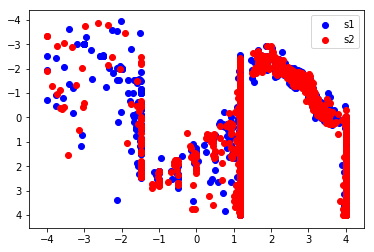

In [570]:
s1 = np.vstack([x[0]['observations']['state_observation'] for x in train_points])
s2 = np.vstack([x[1]['observations']['state_observation'] for x in train_points])

i = np.random.permutation(range(len(s1)))[:2000]
s1_sample = s1[i]
s2_sample = s2[i]

plt.gca().invert_yaxis()
plt.scatter(s1_sample[:,0], s1_sample[:,1], color='b', label="s1")
plt.scatter(s2_sample[:,0], s2_sample[:,1], color='r', label="s2")
plt.legend()

In [151]:
embedding_fns[0]

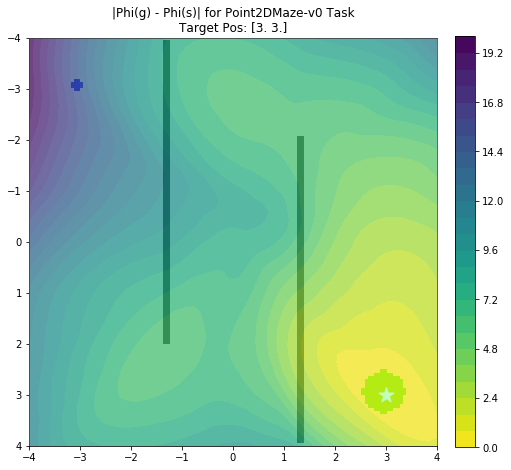

Epoch 460: Loss: 0.028
Epoch 470: Loss: 0.028
Epoch 480: Loss: 0.026
Epoch 490: Loss: 0.028


In [575]:
import random

oracle_embedding = tf.keras.models.clone_model(embedding_fns[0])

# Try training on same data but with oracle distances
oracle_train_loss_results = []
oracle_var_list = oracle_embedding.trainable_variables
oracle_embedding_fns = [oracle_embedding] * 2
    
num_epochs = 500
batch_size = 256
train_data = list(train_points)
random.shuffle(train_data)
train_data = iter(train_data)

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()

    for i in range(10):
        s1, s2 = next(train_data)
        s1 = s1['observations']['state_observation']
        s2 = s2['observations']['state_observation']
        obs = {
            'state_achieved_goal': s1,
            'state_desired_goal': s2
        }
        distance = _generalized_maze_distance(train_env, obs)

        loss_value, grads = grad(oracle_embedding_fns, oracle_var_list, s1, s2, distance)
        optimizer.apply_gradients(zip(grads, oracle_var_list))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss

    # End epoch
    oracle_train_loss_results.append(epoch_loss_avg.result())

    if epoch % 10 == 0:
        print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
    if epoch % 50 == 0:
        clear_output()
        plot_embedding_distances(pos_embedding=oracle_embedding, goal_embedding=oracle_embedding)
#         plot_embedding_distances(target_pos=np.array([-3., -3.]))

## Train using dataset of all distances

In [421]:
s1 = np.array([[-3, -3]])
s2 = np.array([[3, 3]])

combined = np.hstack((s1[:,None], s2[:,None]))
indices = np.argmax((s1[:,0], s2[:,0]), axis=0) # Indices of the points that are farther to the right

left = np.take_along_axis(combined, indices[:,None,None], axis=1).squeeze(axis=1)
right = np.take_along_axis(combined, 1 - indices[:,None,None], axis=1).squeeze(axis=1)

print(left)
print(right)

# larger = np.argmax(test, axis=-1)
# smaller = 1 - larger
# np.take_along_axis(test, larger[:,None], axis=-1)
# np.take_along_axis(test, smaller[:,None], axis=-1)

[[3 3]]
[[-3 -3]]


In [530]:
n_samples = 50
target_pos = train_env.unwrapped._get_obs()['state_desired_goal']
goal_vals = np.repeat(target_pos[None], n_samples * n_samples, axis=0)
grid_vals, xys = get_grid_vals(train_env, n_samples)

################################
# Option 1: Goal distances only
################################
# s1, s2 = grid_vals, goal_vals

################################
# Option 2: All pairs of points
################################
grid_vals, _ = get_grid_vals(train_env, 50)
s1_indices, s2_indices = np.meshgrid(range(len(grid_vals)), range(len(grid_vals)))
s1, s2 = grid_vals[s1_indices.flatten()], grid_vals[s2_indices.flatten()]

obs = {'state_achieved_goal': s1, 'state_desired_goal': s2}

features = (s1, s2)
labels = _generalized_maze_distance(train_env, obs)
gt_dataset = tf.data.Dataset.from_tensor_slices((features, labels))

In [496]:
print(s1)
print(s2)

[[-4.         -4.        ]
 [-3.83673469 -4.        ]
 [-3.67346939 -4.        ]
 ...
 [ 3.67346939  4.        ]
 [ 3.83673469  4.        ]
 [ 4.          4.        ]]
[[-4. -4.]
 [-4. -4.]
 [-4. -4.]
 ...
 [ 4.  4.]
 [ 4.  4.]
 [ 4.  4.]]


In [536]:
obs = {
    'state_achieved_goal': np.array([[-3, -3]]),
    'state_desired_goal': np.array([[-4, -1]])
}
# Should be 3
_generalized_maze_distance(train_env, obs, dist_type="manhattan")

array([3.])

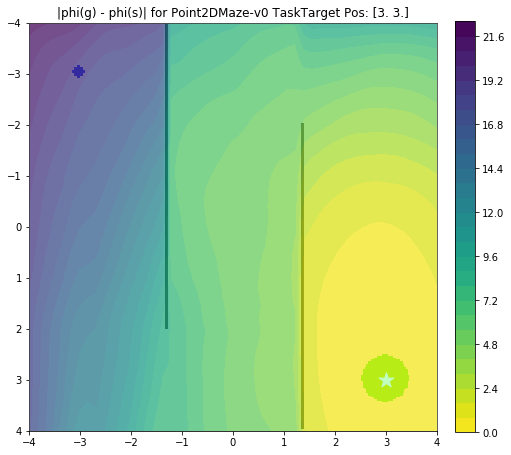

Epoch 160: Loss: 0.052
Epoch 170: Loss: 0.019
Epoch 180: Loss: 0.009
Epoch 190: Loss: 0.010


In [540]:
# Keep results for plotting
train_loss_results = []

if embedding_fns[0] is not embedding_fns[1]:
    var_list = (embedding_fns[0].trainable_variables
                + embedding_fns[1].trainable_variables)
else:
    var_list = embedding_fns[0].trainable_variables
    
num_epochs = 200
batch_size = 64
gt_dataset_iter = iter(gt_dataset.shuffle(2500, reshuffle_each_iteration=True)
                        .repeat(num_epochs)
                        .batch(batch_size))
    
for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()

    for i in range(2500 // batch_size):
        (s1, s2), distance = next(gt_dataset_iter)

        loss_value, grads = grad(embedding_fns, var_list, s1, s2, distance)
        optimizer.apply_gradients(zip(grads, var_list))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())

    if epoch % 10 == 0:
        print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
    if epoch % 50 == 0:
        clear_output()
        plot_embedding_distances()

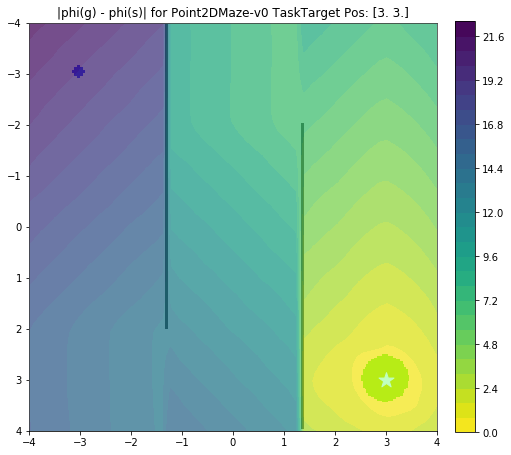

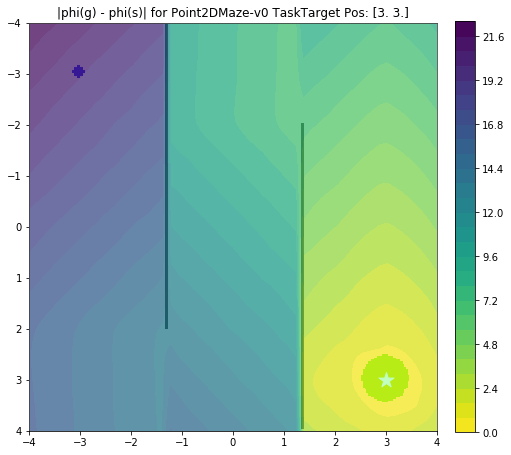

In [415]:
# What if we append the embedding features to the raw x,y state instead?
def predict(pos):
    return np.hstack((embedding_fns[0](pos), pos / 20))
    
plot_embedding_distances()
plot_embedding_distances(predict, predict)

## Visualize embedding

3.0 3.0


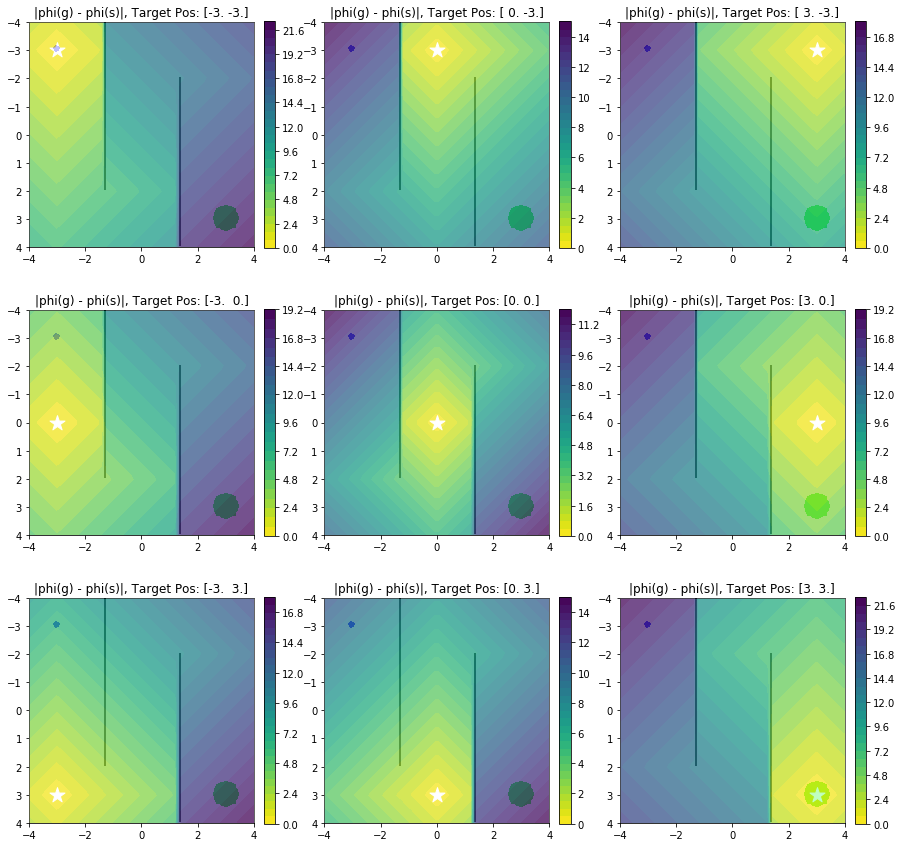

In [461]:
# True distances
true_embedding = lambda s1, s2: _generalized_maze_distance(train_env, \
                                        {'state_achieved_goal': s1, 'state_desired_goal': s2})
plot_embedding_distances_grid(dist_fn=true_embedding)

In [550]:
with open('./old_fixed.pkl', 'rb') as f:
    embedding_fn = pickle.load(f)
embedding_fns = [embedding_fn] * 2

W0606 01:51:47.217427 140736058082176 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [548]:
# !scp kevinli@deepthought:/home/kevinli/reward-learning/notebooks/reward_learning/gt_embedding_fn_pairwise_exp_fixed.pkl ./old_fixed.pkl

Enter passphrase for key '/Users/kevintli/.ssh/rail_id_rsa': 


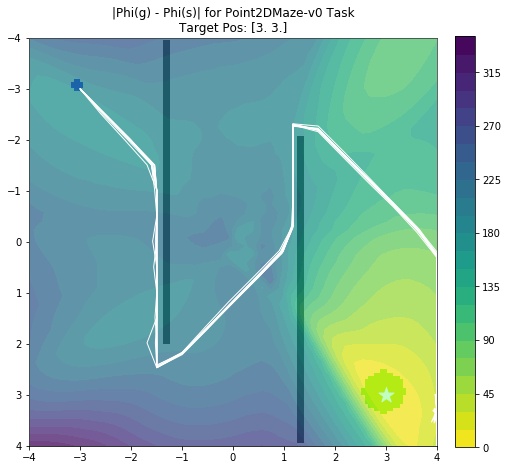

3.0 3.0


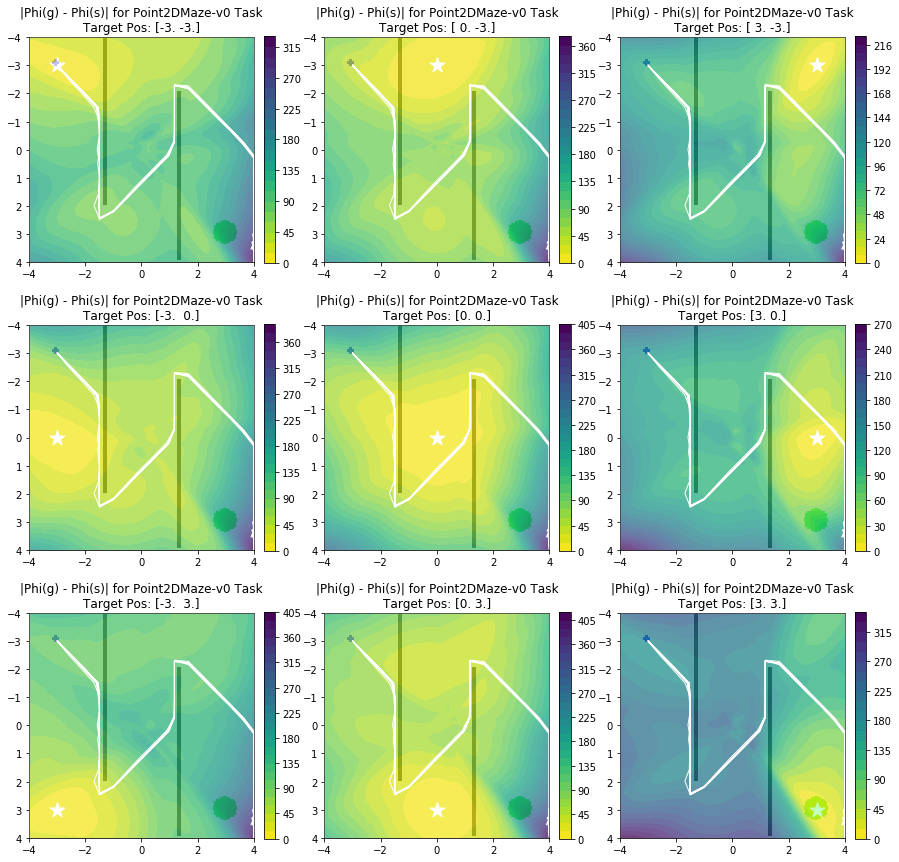

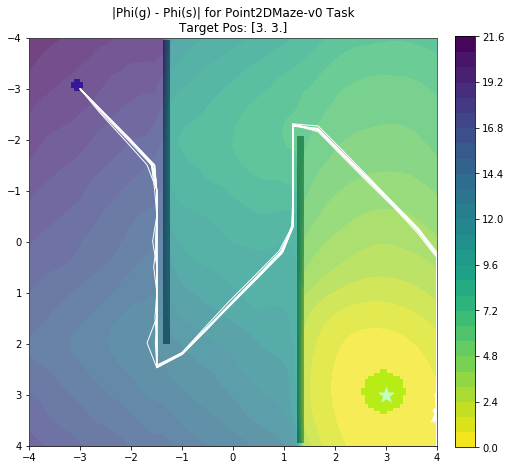

3.0 3.0


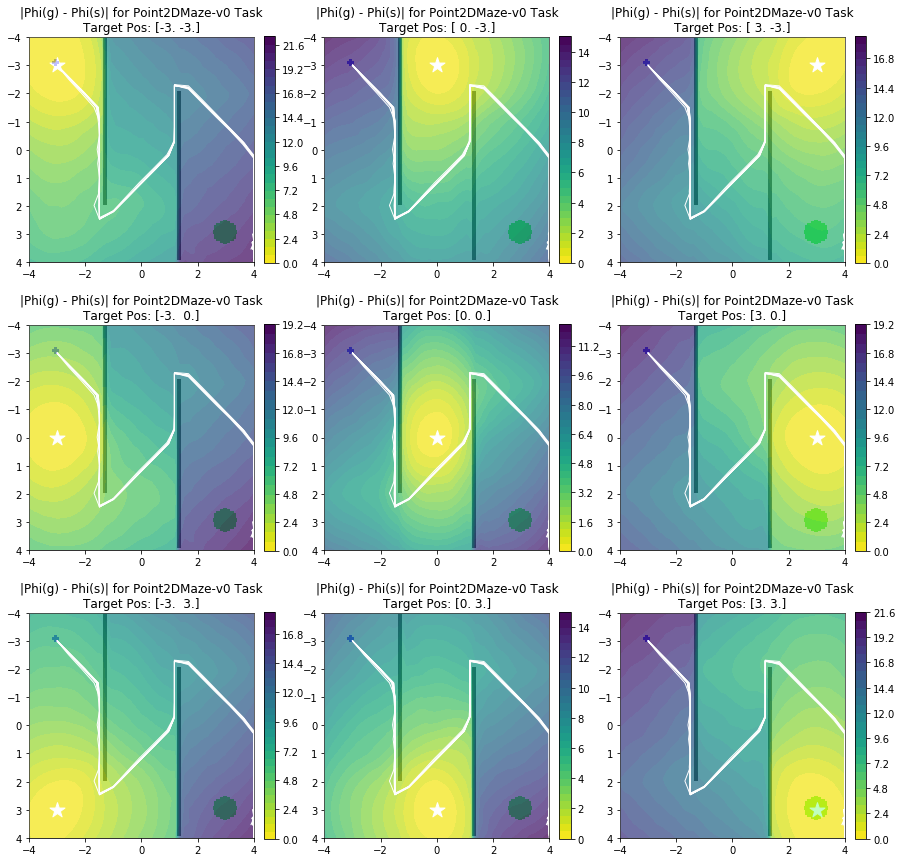

In [573]:
# Predicted distances
plot_embedding_distances(show_trajectories=True)
plot_embedding_distances_grid(show_trajectories=True)

# Oracle distances
plot_embedding_distances(pos_embedding=oracle_embedding, goal_embedding=oracle_embedding, show_trajectories=True)
plot_embedding_distances_grid(pos_embedding=oracle_embedding, goal_embedding=oracle_embedding, show_trajectories=True)

In [22]:
# temp = embedding_fn

In [518]:
# Plug in individual values to inspect
s1 = tf.constant([[-3.5, 3.]])
s2 = tf.constant([[-3.5, 1.]])
pred = tf.reduce_sum(tf.square(embedding_fn(s1) - embedding_fn(s2)), axis=-1)
true = _generalized_maze_distance(train_env, {'state_desired_goal': s2.numpy(), 'state_achieved_goal': s1.numpy()})
print("Predicted:", pred.numpy().item(), "True:", true.item())

Predicted: 2.109048366546631 True: 2.0


3.0 3.0


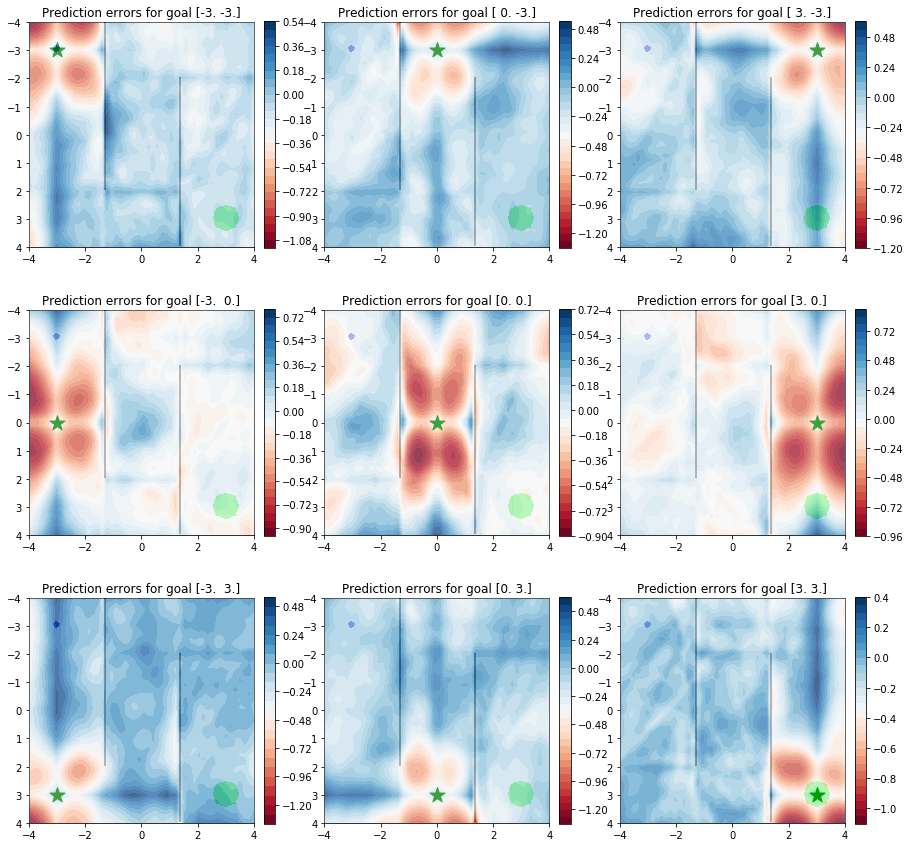

In [528]:
# Plot predictions and errors for top-left goal (should be mirror image of bottom-right)
xs = np.linspace(-3, 3, 3)
ys = np.linspace(-3, 3, 3)
xys = np.meshgrid(xs, ys)
goal_vals = np.array(xys).transpose(1, 2, 0).reshape((9, 2))

n_plots = len(goal_vals)
n_columns = np.ceil(np.sqrt(n_plots))
n_rows = np.ceil(n_plots / n_columns)
print(n_rows, n_columns)
plt.figure(figsize=(5 * n_columns, 5 * n_rows))

for i, goal in enumerate(goal_vals):
    plt.subplot(n_rows, n_columns, i+1, aspect=1)
    s1, xys = get_grid_vals(train_env, 50)
    s2 = np.repeat(goal[None], 50 * 50, axis=0)
    pred = tf.reduce_sum(tf.square(embedding_fn(tf.convert_to_tensor(s1)) - embedding_fn(tf.convert_to_tensor(s2))), axis=-1).numpy()
    true = _generalized_maze_distance(train_env, {'state_desired_goal': s2, 'state_achieved_goal': s1})
    plt.imshow(train_env.render('rgb_array', width=256, height=256),
           extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)
    plt.gca().invert_yaxis()
    plt.scatter(*goal, marker='*', s=250, color='green', zorder=2)
    plt.contourf(xys[0], xys[1], ((pred - true)).reshape(xys[0].shape), levels=30, zorder=1, cmap='RdBu')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title(f"Prediction errors for goal {goal}")

In [542]:
%ls

Untitled.ipynb                          gt_embedding_fn_pairwise.pkl
ddl.ipynb                               gt_embedding_fn_pairwise_exp.pkl
embedding_fn_2.pkl                      gt_embedding_fn_pairwise_exp_fixed.pkl
embedding_fn_seed0.pkl                  pnml.ipynb
embedding_fn_seed6.pkl                  train_embedding.ipynb
ground_truth_embedding.ipynb            vice_reward_visualizations.ipynb
gt_embedding_fn.pkl


In [543]:
with open('./gt_embedding_fn_pairwise.pkl', 'rb') as f:
    old_embedding = pickle.load(f)

W0606 01:48:15.156696 140736058082176 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Text(0.5, 1.0, 'Singular values of maze embeddings')

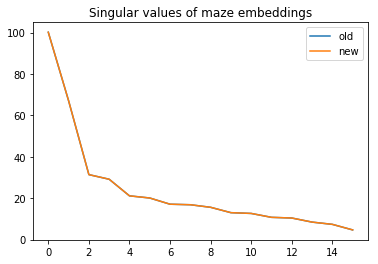

In [534]:
plt.figure()
for name, model in [("old", old_embedding), ("new", embedding_fns[0])]:
    U, S, V = np.linalg.svd(model(grid_vals))
    plt.plot(S, label=name)
plt.legend()
plt.title("Singular values of maze embeddings")

In [525]:
# Visualize using multi-dimensional scaling
from sklearn.datasets import load_digits
from sklearn.manifold import MDS

grid_vals, _ = get_grid_vals(train_env, 50)
embeddings = tf.cast(embedding_fns[0](grid_vals), tf.float64)
mds = MDS(n_components=2)
projected = mds.fit_transform(embeddings)
projected

array([[ 2.8742964 , -1.19408629],
       [ 2.82514104, -1.21674736],
       [ 2.80805138, -1.15961397],
       ...,
       [-2.79341221,  1.16204664],
       [-2.81234114,  1.21041279],
       [-2.85902303,  1.20677644]])

In [252]:
i = np.argmin(np.linalg.norm(projected - np.array([0.15, 0.15]), axis=-1))
print(f"i={i}")
print(f"projected: {projected[i]}")
print(f"embedding: {embeddings[i]}")
print(f"grid val: {grid_vals[i]}")

i=1191
projected: [0.15323566 0.1453224 ]
embedding: [-0.06868646 -0.00480905 -0.04438797  0.02983699 -0.07066549 -0.06758156
  0.01051372  0.10641114  0.13768101 -0.02119337 -0.07215976 -0.09597219
  0.06796773 -0.06533718 -0.01072475 -0.0229781 ]
grid val: [ 2.69387755 -0.24489796]


In [76]:
np.repeat([[255, 255, 255]], 5, axis=0)
labels

array([22.        , 21.83673469, 21.67346939, ...,  1.67346939,
        1.83673469,  2.        ])

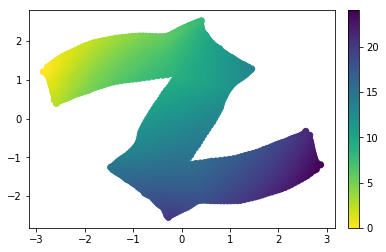

In [531]:
plt.scatter(projected[:,0], projected[:,1], c=labels[-2500:], cmap='viridis_r')
plt.colorbar(fraction=0.046, pad=0.04)

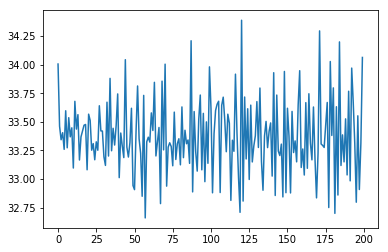

In [125]:
plt.plot(train_loss_results)

In [532]:
with open('./gt_embedding_fn_pairwise_exp_fixed.pkl', 'wb') as f:
    pickle.dump(embedding_fn, f)

In [117]:
%ls

Untitled.ipynb                    gt_embedding_fn.pkl
ddl.ipynb                         pnml.ipynb
embedding_fn_2.pkl                train_embedding.ipynb
embedding_fn_seed0.pkl            vice_reward_visualizations.ipynb
embedding_fn_seed6.pkl


### Plot distance predictions using the learned embedding

In [167]:
def plot_embedding():
    target_pos = train_env.unwrapped._get_obs()['state_desired_goal']

    n_samples = 50
    obs_space = train_env.observation_space['state_observation']
    xs = np.linspace(obs_space.low[0], obs_space.high[0], n_samples)
    ys = np.linspace(obs_space.low[1], obs_space.high[1], n_samples)

    xys = np.meshgrid(xs, ys)

    grid_vals = np.array(xys).transpose(1, 2, 0).reshape((n_samples * n_samples, 2))
    goal_vals = np.repeat(target_pos[None], n_samples * n_samples, axis=0)
    dists = np.linalg.norm(embedding_fns[1].predict(goal_vals) - embedding_fns[0].predict(grid_vals), axis=-1)

    plt.figure(figsize=(8, 8))

    plt.imshow(train_env.render('rgb_array', width=256, height=256),
               extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)

    plt.gca().invert_yaxis()
    plt.contourf(xys[0], xys[1], dists.reshape(xys[0].shape), levels=30, zorder=1, cmap='viridis_r')
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.scatter(*target_pos, marker='*', s=250, color='white', zorder=2)

    plt.title(f'|phi(g) - phi(s)| for {domain + task} Task'
              + f'Target Pos: {target_pos}')
    plt.show()

NameError: name 'target_pos' is not defined

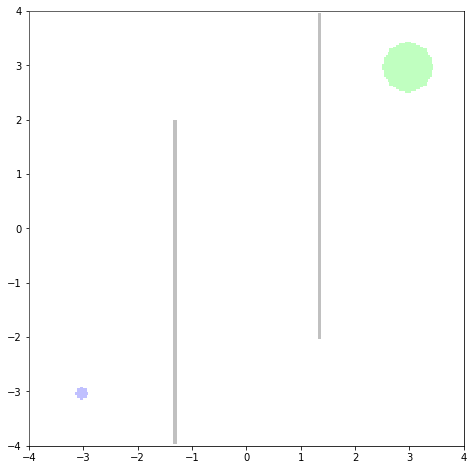

In [29]:
num_traj = 20

trajs = replay_pool.last_n_batch(max_path_length * num_traj)

plt.figure(figsize=(8, 8))

plt.imshow(train_env.render('rgb_array', width=256, height=256),
           extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)
plt.scatter(*target_pos, marker='*', s=250, color='white', zorder=2)

for i in range(num_traj):
    trajectory = trajs['observations']['state_observation'][i*max_path_length:max_path_length*(i+1)]
    plt.plot(trajectory[:, 0], trajectory[:, 1], 'black')

radii = np.arange(0.5, 9, 0.5)
circles = []
for r in radii:
    pts = []
    for theta in np.arange(0, 2 * np.pi + np.pi / 30, np.pi / 30):
        dx = r * np.cos(theta)
        dy = r * np.sin(theta)
        pt = target_pos + np.array([dx, dy])
        x, y = pt
        if -4 <= x and x <= 4 and -4 <= y and y <= 4:
            pts.append(np.array([[x, y]]))
    circles.append(np.vstack(pts))

for circle in circles:
    plt.plot(circle[:, 0], circle[:, 1])
    
plt.gca().invert_yaxis()

plt.title(f'|phi(g) - phi(s)| for {domain + task} Task\n'
          + f'Target Pos: {target_pos}')
plt.show()

In [209]:
replay_pool.data[('observations', 'state_observation')]

array([[-3.       , -3.       ],
       [-2.5025456, -2.5269508],
       [-2.0109699, -2.0578551],
       ...,
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ],
       [ 0.       ,  0.       ]], dtype=float32)

201000


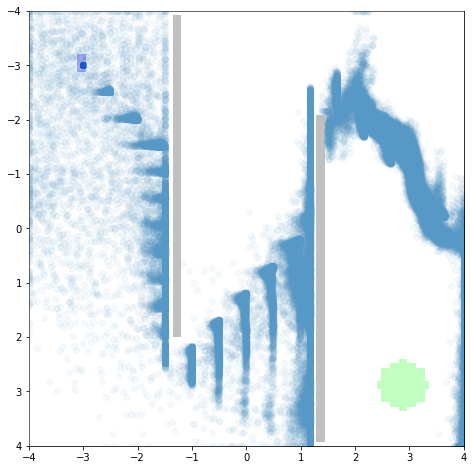

In [238]:
non_zero_rows = replay_pool.data[('observations', 'state_observation')].any(axis=-1)
visitations = replay_pool.data[('observations', 'state_observation')][non_zero_rows]
print(len(visitations))
plt.figure(figsize=(8, 8))
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().invert_yaxis()
plt.imshow(train_env.render('rgb_array'),
           extent=(-4, 4, -4, 4),
           origin='lower',
           alpha=0.25,
           zorder=3,
           interpolation='nearest')

plt.scatter(visitations[:, 0], visitations[:, 1], alpha=0.05)

ValueError: need at least one array to concatenate

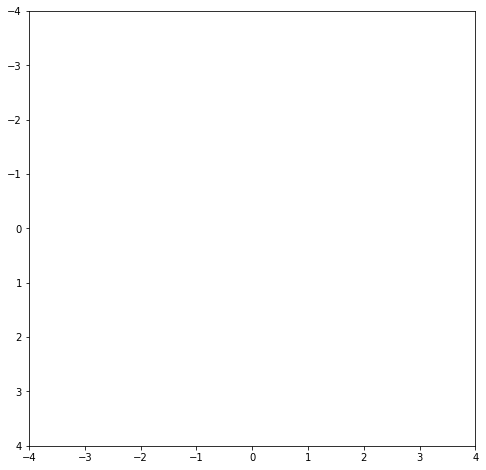

In [31]:
plt.figure(figsize=(8, 8))
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().invert_yaxis()
end_state_idxs = np.arange(99, replay_pool.size, 100)
end_states = replay_pool.data[('observations', 'state_observation')][non_zero_rows][end_state_idxs]

success = np.where(np.linalg.norm(end_states - np.array([3, 3]), axis=-1) < 1)[0]
include_idxs = end_state_idxs[success]
include_idxs.shape

all_idxs_to_include = np.concatenate([
    np.arange(include_idx - 99, include_idx + 1)
    for include_idx in include_idxs
])

success_data = replay_pool.data[('observations', 'state_observation')][non_zero_rows][all_idxs_to_include]

# plt.scatter(end_states[:, 0], end_states[:, 1], alpha=0.05)
plt.scatter(end_states[success][:, 0], end_states[success][:, 1], alpha=0.05)

In [32]:
success_data.shape

NameError: name 'success_data' is not defined

In [33]:
replay_pool.data[('observations', 'state_observation')][non_zero_rows][0]

array([-3., -3.], dtype=float32)

In [34]:
np.arange(99, replay_pool.size, 100)

array([    99,    199,    299, ..., 999799, 999899, 999999])

# Use a Distance Function Instead

In [35]:
from softlearning.models.utils import get_distance_estimator_from_variant

variant['distance_fn_params'] = {
    'type': 'feedforward_distance_fn',
    'kwargs': {
        'hidden_layer_sizes': (256, ) * 2,
        'observation_keys': None,
        'observation_keys': ('state_observation', ),
#         'kernel_regularizer': tf.keras.regularizers.l2(5e-4)
    }
}

distance_fn = get_distance_estimator_from_variant(variant, train_env)

In [36]:
ddl_optimizer = tf.compat.v1.train.AdamOptimizer(
    learning_rate=3e-4,
    name='distance_fn_optimizer')

loss_object = tf.keras.losses.MeanSquaredError()
def loss(model, s1, s2, distance):
    return loss_object(y_true=distance, y_pred=model([s1, s2]))

def grad(model, s1, s2, distance):
    with tf.GradientTape() as tape:
        loss_value = loss(model, s1, s2, distance)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [37]:
# Keep results for plotting
train_loss_results = []

num_epochs = 501
batch_size = 64

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()

    for i in range(10):
        s1, s2, distance = get_data(replay_pool,
                                    max_path_length,
                                    batch_size=batch_size)

        loss_value, grads = grad(distance_fn, s1, s2, distance)
        optimizer.apply_gradients(zip(grads, distance_fn.trainable_variables))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())

    if epoch % 10 == 0:
        print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))
    if epoch % 50 == 0:
        clear_output()
        plot_embedding()

InvalidArgumentError: cannot compute ConcatV2 as input #1(zero-based) was expected to be a float tensor but is a uint64 tensor [Op:ConcatV2] name: concat

In [104]:
def plot_embedding():
    target_pos = train_env.unwrapped._get_obs()['state_desired_goal']

    n_samples = 50
    obs_space = train_env.observation_space['state_observation']
    xs = np.linspace(obs_space.low[0], obs_space.high[0], n_samples)
    ys = np.linspace(obs_space.low[1], obs_space.high[1], n_samples)

    xys = np.meshgrid(xs, ys)

    grid_vals = np.array(xys).transpose(1, 2, 0).reshape((n_samples * n_samples, 2))
    goal_vals = np.repeat(target_pos[None], n_samples * n_samples, axis=0)
    dists = distance_fn.predict([grid_vals, goal_vals])

    plt.figure(figsize=(8, 8))

    plt.imshow(train_env.render('rgb_array', width=256, height=256),
               extent=(-4, 4, -4, 4), origin='lower', alpha=0.25, zorder=3)

    plt.gca().invert_yaxis()
    plt.contourf(xys[0], xys[1], dists.reshape(xys[0].shape), levels=30, zorder=1)
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.scatter(*target_pos, marker='*', s=250, color='white', zorder=2)

    plt.title(f'd(s, g) for {domain + task} Task'
              + f'Target Pos: {target_pos}')
    plt.show()